In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    matthews_corrcoef,
    classification_report,
    confusion_matrix,
    roc_curve
)

import matplotlib.pyplot as plt
import seaborn as sns
import pickle


In [2]:
#Load & Schema Fix
df = pd.read_csv("../dataset/telco_train.csv")
# Fix TotalCharges issue
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

### Effect of Derived Features
y = df["Churn"].map({"No": 0, "Yes": 1})
X = df.drop(columns=["Churn", "customerID"], errors="ignore")

num_features = X.select_dtypes(include=["int64", "float64"]).columns
cat_features = X.select_dtypes(include=["object"]).columns




In [3]:
numeric_pipeline = Pipeline([
    ("imputer", IterativeImputer(random_state=42)),
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_pipeline, num_features),
    ("cat", categorical_pipeline, cat_features)
])



In [4]:
model = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
])


In [5]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [6]:
model.fit(X_train, y_train)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('classifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transforme

In [7]:
y_pred = model.predict(X_val)

print("Accuracy:", accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred))


Accuracy: 0.7542147293700089
              precision    recall  f1-score   support

           0       0.91      0.74      0.82       828
           1       0.52      0.80      0.63       299

    accuracy                           0.75      1127
   macro avg       0.72      0.77      0.72      1127
weighted avg       0.81      0.75      0.77      1127



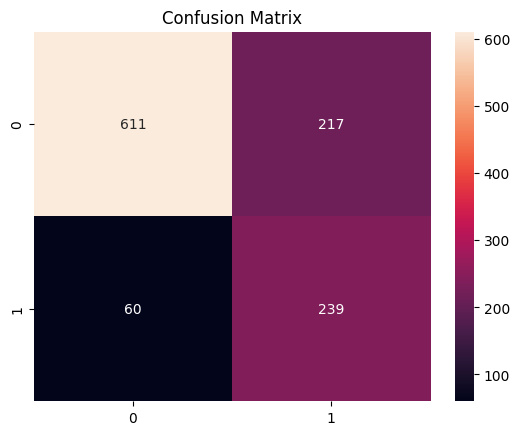

In [8]:
sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.show()


In [9]:
feature_names = model.named_steps["preprocessor"].get_feature_names_out()
coefficients = model.named_steps["classifier"].coef_[0]

importance = (
    pd.Series(coefficients, index=feature_names)
      .sort_values(key=abs, ascending=False)
)

importance.head(50)


num__tenure                                    -1.136222
cat__Contract_Two year                         -0.863544
cat__Contract_Month-to-month                    0.721821
cat__InternetService_Fiber optic                0.672406
cat__InternetService_DSL                       -0.600776
num__MonthlyCharges                            -0.573638
num__TotalCharges                               0.479818
cat__TechSupport_No internet service           -0.254646
cat__DeviceProtection_No internet service      -0.254646
cat__InternetService_No                        -0.254646
cat__OnlineSecurity_No internet service        -0.254646
cat__StreamingMovies_No internet service       -0.254646
cat__StreamingTV_No internet service           -0.254646
cat__OnlineBackup_No internet service          -0.254646
cat__StreamingTV_Yes                            0.253182
cat__StreamingMovies_Yes                        0.243827
cat__MultipleLines_No                          -0.238282
cat__Dependents_Yes            

In [10]:
with open("../models/logistic_regression_model.pkl", "wb") as f:
    pickle.dump(model, f)

print("Model saved as logistic_regression_model.pkl")


Model saved as logistic_regression_model.pkl


In [11]:
print(importance.get("cat__Fiber_and_MonthToMonth", "Feature not found in list"))
# Note: If you added it to numerical_cols, it might be named "num__Fiber_and_MonthToMonth"


Feature not found in list


In [12]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 1. Load the separate Test CSV
test_df = pd.read_csv('../dataset/telco_test.csv')

# --- FIX: Apply cleaning to test_df, NOT df ---
# pd.to_numeric with errors='coerce' automatically turns ' ' into NaN
test_df["TotalCharges"] = pd.to_numeric(test_df["TotalCharges"], errors="coerce")
test_df['TotalCharges'] = test_df['TotalCharges'].fillna(0)

# 2. Separate Features and Target
X_final_test = test_df.drop(columns=['Churn'])
# Make sure Churn is numeric
y_final_test = test_df['Churn'].map({'Yes': 1, 'No': 0})

# 3. Use the ALREADY TRAINED 'model' (your pipeline) to predict
# The pipeline will handle Scaling and OneHotEncoding automatically
y_final_pred = model.predict(X_final_test)

# 4. Display the Final Performance
print("========== OFFICIAL TEST SET PERFORMANCE ==========")
print(f"Accuracy: {accuracy_score(y_final_test, y_final_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_final_test, y_final_pred))

========== OFFICIAL TEST SET PERFORMANCE ==========
Accuracy: 0.7410

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.72      0.80      1035
           1       0.51      0.79      0.62       374

    accuracy                           0.74      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.80      0.74      0.75      1409



In [13]:
import pickle
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score

# 1. Load the model from the file
with open("../models/logistic_regression_model.pkl", "rb") as f:
    loaded_model = pickle.load(f)

# 2. Load and clean your test data (if not already in memory)
test_df = pd.read_csv('../dataset/telco_test.csv')
test_df["TotalCharges"] = pd.to_numeric(test_df["TotalCharges"], errors="coerce").fillna(0)

X_final_test = test_df.drop(columns=['Churn'])
y_final_test = test_df['Churn'].map({'Yes': 1, 'No': 0})

# 3. Predict using the LOADED model
y_loaded_pred = loaded_model.predict(X_final_test)

# 4. Final Verification
print("========== TEST FROM SAVED PKL FILE ==========")
print(f"Accuracy: {accuracy_score(y_final_test, y_loaded_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_final_test, y_loaded_pred))

========== TEST FROM SAVED PKL FILE ==========
Accuracy: 0.7410

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.72      0.80      1035
           1       0.51      0.79      0.62       374

    accuracy                           0.74      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.80      0.74      0.75      1409

